In [2]:
import os
import glob

import tqdm
import numpy as np
import scipy.ndimage
import scipy.misc
import sklearn.metrics

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

from collections import defaultdict

import random

import keras
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras.layers.core import Dense, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D, GlobalMaxPooling2D

import argparse
IMG_SIZE = (128,128)

In [97]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# load data as numpy array
# for image_path in tqdm.tqdm(list(glob.glob('/content/drive/My Drive/cs 229/train_another/**/*.jpeg'))):
#     image = Image.open(image_path)
#     image_pixels = np.array(image)
#     image_basepath, _ = os.path.splitext(image_path)
#     np.savez(image_basepath+'.npz', pixels=image_pixels)

In [3]:
class DataEncoder():
    def __init__(self, all_damage_labels):
        self.all_damage_labels = all_damage_labels

    def one_hot_index(self, damage_label):
        return self.all_damage_labels.index(damage_label)

    def one_hot_decode(self, predicted_labels):
        return dict(zip(self.all_damage_labels, predicted_labels))

    def one_hot_encode(self, damage_label):
        one_hot_encoded_vector = np.zeros(len(self.all_damage_labels))
        idx = self.one_hot_index(damage_label)
        one_hot_encoded_vector[idx] = 1
        return one_hot_encoded_vector

In [4]:
image_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=.15,
    height_shift_range=.15,
    shear_range=0.15,
    zoom_range=0.15,
    channel_shift_range=1,
    horizontal_flip=True,
    vertical_flip=False,
)

In [5]:
class DataGenerator():
    def __init__(self, data_path):
        self.data_path = data_path
        self.partition2damage2npz = {
            'train': defaultdict(list),
            'validation': defaultdict(list),
            'test': defaultdict(list),
        }
        self.all_damage_labels = set()
        npz_file_listing = list(glob.glob(os.path.join(data_path, '**/*.npz')))
        for npz_path in npz_file_listing:
            damage = os.path.basename(os.path.dirname(npz_path))
            self.all_damage_labels.add(damage)
            if hash(npz_path) % 10 < 7:
                partition = 'train'
            elif 7 <= hash(npz_path) % 10 < 9:
                partition = 'validation'
            elif 9 == hash(npz_path) % 10:
                partition = 'test'
            else:
                raise Exception("partition not assigned")
            self.partition2damage2npz[partition][damage].append(npz_path)
        self.encoder = DataEncoder(sorted(list(self.all_damage_labels)))

    def _pair_generator(self, partition, augmented=True):
        partition_data = self.partition2damage2npz[partition].items()
        while True:
            for damage, npzs in partition_data:
                npz_path = random.choice(npzs)
                pixels = np.load(npz_path)['pixels']
                one_hot_encoded_labels = self.encoder.one_hot_encode(damage)
                if augmented:
                    augmented_pixels = next(
                        image_datagen.flow(np.array([pixels]))
                    )[0].astype(np.uint8)
                    yield augmented_pixels, one_hot_encoded_labels
                else:
                    yield pixels, one_hot_encoded_labels


    def batch_generator(self, partition, batch_size, augmented=True):
        while True:
            data_gen = self._pair_generator(partition, augmented)
            pixels_batch, one_hot_damage_batch = zip(
                *[next(data_gen) for _ in range(batch_size)]
            )
            pixels_batch = np.array(pixels_batch)
            one_hot_damage_batch = np.array(one_hot_damage_batch)
            yield pixels_batch, one_hot_damage_batch

In [6]:
IN_SHAPE = (*IMG_SIZE, 3)

def get_model(all_damage_labels):
    pretrained_model = VGG19(
                include_top=False,
                input_shape=IN_SHAPE,
                weights='imagenet'
            )
    
    if pretrained_model.output.shape.ndims > 2:
        output = Flatten()(pretrained_model.output)
    else:
        output = pretrained_model.output
        
    output = BatchNormalization()(output)
    output = Dropout(0.5)(output)
    output = Dense(128, activation='relu')(output)
    output = BatchNormalization()(output)
    output = Dropout(0.5)(output)
    output = Dense(len(all_damage_labels), activation='softmax')(output)
    model = Model(pretrained_model.input, output)
    for layer in pretrained_model.layers:
        layer.trainable = False
    model.summary(line_length=200)

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

## Without Augmentation

In [32]:
BATCH_SIZE = 64

# Think we need a TensorBoard install for this part of the code
# tensorboard_callback = keras.callbacks.TensorBoard(
#         log_dir=args.tensorboard_directory,
#         histogram_freq=0,
#         write_graph=True,
#         write_images=False
#     )

# Think this is for saving the model
# save_model_callback = keras.callbacks.ModelCheckpoint( 
#     os.path.join(args.weight_directory, 'weights.{epoch:02d}.h5'),
#     verbose=3,
#     save_best_only=False,
#     save_weights_only=False,
#     mode='auto',
#     period=1
# )

# data_dir = '/content/drive/My Drive/cs 229/train_another' #<- for images on Google Drive
data_dir = '/Users/jimbest-devereux/Desktop/Autumn/CS 229/Project/Post-hurricane/train_another' #<- for local

data_generator = DataGenerator(data_dir)

model = get_model(data_generator.encoder.all_damage_labels
)

model.fit_generator(
    data_generator.batch_generator('train', batch_size=BATCH_SIZE),
    steps_per_epoch=200,
    epochs=15,
    validation_data=data_generator.batch_generator(
        'validation',
        batch_size=BATCH_SIZE,
        augmented=False
    ),
    validation_steps=10
#     callbacks=[save_model_callback, tensorboard_callback], #<--Think this is for the above callbacks
#    workers=4 <- causes it to break, need multiprocessing = True
)

Model: "functional_3"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                                              Output Shape                                                                    Param #                       
input_2 (InputLayer)                                                                      [(None, 128, 128, 3)]                                                           0                             
________________________________________________________________________________________________________________________________________________________________________________________________________
block1_conv1 (Conv2D)                                                                     (None, 128, 128, 64)                                                            1792

Epoch 1/15
200/200 [==============================] - 1976s 10s/step - loss: 0.3893 - accuracy: 0.8647 - val_loss: 0.2662 - val_accuracy: 0.9281
Epoch 2/15
200/200 [==============================] - 2154s 11s/step - loss: 0.2625 - accuracy: 0.8901 - val_loss: 0.1453 - val_accuracy: 0.9391
Epoch 3/15
200/200 [==============================] - 1907s 10s/step - loss: 0.2281 - accuracy: 0.9018 - val_loss: 0.1724 - val_accuracy: 0.9375
Epoch 4/15
200/200 [==============================] - 1759s 9s/step - loss: 0.2108 - accuracy: 0.9138 - val_loss: 0.1701 - val_accuracy: 0.9328
Epoch 5/15
200/200 [==============================] - 1825s 9s/step - loss: 0.2001 - accuracy: 0.9175 - val_loss: 0.1425 - val_accuracy: 0.9406
Epoch 6/15
200/200 [==============================] - 1832s 9s/step - loss: 0.1921 - accuracy: 0.9209 - val_loss: 0.1292 - val_accuracy: 0.9531
Epoch 7/15
200/200 [==============================] - 1765s 9s/step - loss: 0.1884 - accuracy: 0.9220 - val_loss: 0.1332 - val_accura

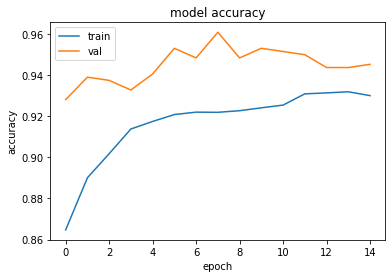

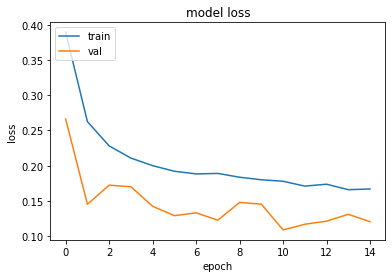

In [33]:
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## With Augmentation

Epoch 1/15
200/200 [==============================] - 1064s 5s/step - loss: 0.1661 - accuracy: 0.9295 - val_loss: 0.1838 - val_accuracy: 0.9250
Epoch 2/15
200/200 [==============================] - 1017s 5s/step - loss: 0.1630 - accuracy: 0.9324 - val_loss: 0.2176 - val_accuracy: 0.9125
Epoch 3/15
200/200 [==============================] - 1014s 5s/step - loss: 0.1678 - accuracy: 0.9312 - val_loss: 0.1193 - val_accuracy: 0.9578
Epoch 4/15
200/200 [==============================] - 1020s 5s/step - loss: 0.1545 - accuracy: 0.9366 - val_loss: 0.1263 - val_accuracy: 0.9531
Epoch 5/15
200/200 [==============================] - 1015s 5s/step - loss: 0.1605 - accuracy: 0.9358 - val_loss: 0.1739 - val_accuracy: 0.9391
Epoch 6/15
200/200 [==============================] - 1013s 5s/step - loss: 0.1582 - accuracy: 0.9359 - val_loss: 0.1706 - val_accuracy: 0.9297
Epoch 7/15
200/200 [==============================] - 1011s 5s/step - loss: 0.1583 - accuracy: 0.9363 - val_loss: 0.1228 - val_accuracy:

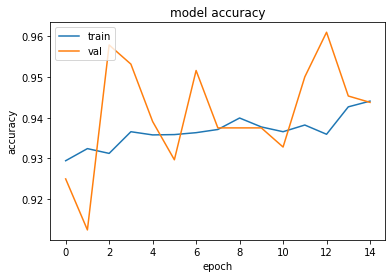

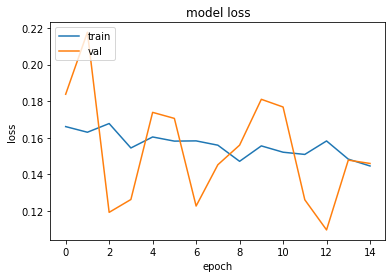

In [34]:
model.fit_generator(
    data_generator.batch_generator('train', batch_size=BATCH_SIZE),
    steps_per_epoch=200,
    epochs=15,
    validation_data=data_generator.batch_generator(
        'validation',
        batch_size=BATCH_SIZE,
        augmented=True
    ),
    validation_steps=10
)

# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Shrunk Training Set

In [55]:
class DataGenerator():
    def __init__(self, data_path, amount):
        self.amount = amount
        self.data_path = data_path
        self.partition2damage2npz = {
            'train': defaultdict(list),
            'validation': defaultdict(list),
            'test': defaultdict(list),
        }
        self.all_damage_labels = set()
        npz_file_listing = list(glob.glob(os.path.join(data_path, '**/*.npz')))
        for npz_path in npz_file_listing:
            damage = os.path.basename(os.path.dirname(npz_path))
            self.all_damage_labels.add(damage)
            if hash(npz_path) % 10 < 7:
                partition = 'train'
            elif 7 <= hash(npz_path) % 10 < 9:
                partition = 'validation'
            elif 9 == hash(npz_path) % 10:
                partition = 'test'
            else:
                raise Exception("partition not assigned")
            self.partition2damage2npz[partition][damage].append(npz_path)
        self.encoder = DataEncoder(sorted(list(self.all_damage_labels)))

    def _pair_generator(self, partition, augmented=True):
        if partition == 'train':
            train_partition = {}
            train_data = self.partition2damage2npz[partition]
            for key in train_data.keys():
                train_partition[key] = random.choices(train_data[key], k=int(len(train_data[key])*self.amount))
            partition_data = train_partition.items()
        else:  
            partition_data = self.partition2damage2npz[partition].items()

        
        while True:
            for damage, npzs in partition_data:
                npz_path = random.choice(npzs)
                pixels = np.load(npz_path)['pixels']
                one_hot_encoded_labels = self.encoder.one_hot_encode(damage)
                if augmented:
                    augmented_pixels = next(
                        image_datagen.flow(np.array([pixels]))
                    )[0].astype(np.uint8)
                    yield augmented_pixels, one_hot_encoded_labels
                else:
                    yield pixels, one_hot_encoded_labels


    def batch_generator(self, partition, batch_size, augmented=True):
        while True:
            data_gen = self._pair_generator(partition, augmented)
            pixels_batch, one_hot_damage_batch = zip(
                *[next(data_gen) for _ in range(batch_size)]
            )
            pixels_batch = np.array(pixels_batch)
            one_hot_damage_batch = np.array(one_hot_damage_batch)
            yield pixels_batch, one_hot_damage_batch

Model: "functional_21"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                                              Output Shape                                                                    Param #                       
input_11 (InputLayer)                                                                     [(None, 128, 128, 3)]                                                           0                             
________________________________________________________________________________________________________________________________________________________________________________________________________
block1_conv1 (Conv2D)                                                                     (None, 128, 128, 64)                                                            179

Epoch 1/15
200/200 [==============================] - 1024s 5s/step - loss: 0.4301 - accuracy: 0.8540 - val_loss: 0.1352 - val_accuracy: 0.9297
Epoch 2/15
200/200 [==============================] - 1018s 5s/step - loss: 0.2604 - accuracy: 0.8933 - val_loss: 0.1741 - val_accuracy: 0.9328
Epoch 3/15
200/200 [==============================] - 1021s 5s/step - loss: 0.2215 - accuracy: 0.9070 - val_loss: 0.1568 - val_accuracy: 0.9422
Epoch 4/15
200/200 [==============================] - 1029s 5s/step - loss: 0.2116 - accuracy: 0.9107 - val_loss: 0.1473 - val_accuracy: 0.9422
Epoch 5/15
200/200 [==============================] - 1043s 5s/step - loss: 0.2023 - accuracy: 0.9153 - val_loss: 0.1485 - val_accuracy: 0.9406
Epoch 6/15
200/200 [==============================] - 1024s 5s/step - loss: 0.2008 - accuracy: 0.9172 - val_loss: 0.1727 - val_accuracy: 0.9281
Epoch 7/15
200/200 [==============================] - 1026s 5s/step - loss: 0.1919 - accuracy: 0.9205 - val_loss: 0.1444 - val_accuracy:

Epoch 1/15
200/200 [==============================] - 1039s 5s/step - loss: 0.4003 - accuracy: 0.8605 - val_loss: 0.1396 - val_accuracy: 0.9328
Epoch 2/15
200/200 [==============================] - 1162s 6s/step - loss: 0.2562 - accuracy: 0.8924 - val_loss: 0.1625 - val_accuracy: 0.9203
Epoch 3/15
200/200 [==============================] - 1077s 5s/step - loss: 0.2386 - accuracy: 0.8989 - val_loss: 0.1355 - val_accuracy: 0.9391
Epoch 4/15
200/200 [==============================] - 1040s 5s/step - loss: 0.2155 - accuracy: 0.9105 - val_loss: 0.1919 - val_accuracy: 0.9297
Epoch 5/15
200/200 [==============================] - 1039s 5s/step - loss: 0.2040 - accuracy: 0.9135 - val_loss: 0.1465 - val_accuracy: 0.9328
Epoch 6/15
200/200 [==============================] - 1307s 7s/step - loss: 0.1993 - accuracy: 0.9166 - val_loss: 0.1652 - val_accuracy: 0.9281
Epoch 7/15
200/200 [==============================] - 1380s 7s/step - loss: 0.1897 - accuracy: 0.9215 - val_loss: 0.1450 - val_accuracy:

Epoch 1/15
200/200 [==============================] - 1035s 5s/step - loss: 0.4400 - accuracy: 0.8543 - val_loss: 0.2021 - val_accuracy: 0.9172
Epoch 2/15
200/200 [==============================] - 1038s 5s/step - loss: 0.2620 - accuracy: 0.8943 - val_loss: 0.1307 - val_accuracy: 0.9516
Epoch 3/15
200/200 [==============================] - 1035s 5s/step - loss: 0.2245 - accuracy: 0.9047 - val_loss: 0.1393 - val_accuracy: 0.9453
Epoch 4/15
200/200 [==============================] - 1043s 5s/step - loss: 0.2253 - accuracy: 0.9058 - val_loss: 0.1530 - val_accuracy: 0.9344
Epoch 5/15
200/200 [==============================] - 1038s 5s/step - loss: 0.2023 - accuracy: 0.9153 - val_loss: 0.2034 - val_accuracy: 0.9266
Epoch 6/15
200/200 [==============================] - 1037s 5s/step - loss: 0.1976 - accuracy: 0.9150 - val_loss: 0.1914 - val_accuracy: 0.9344
Epoch 7/15
200/200 [==============================] - 1042s 5s/step - loss: 0.1929 - accuracy: 0.9195 - val_loss: 0.1782 - val_accuracy:

Epoch 1/15
200/200 [==============================] - 1157s 6s/step - loss: 0.4128 - accuracy: 0.8567 - val_loss: 0.2785 - val_accuracy: 0.9109
Epoch 2/15
200/200 [==============================] - 1131s 6s/step - loss: 0.2668 - accuracy: 0.8920 - val_loss: 0.2133 - val_accuracy: 0.9234
Epoch 3/15
200/200 [==============================] - 1029s 5s/step - loss: 0.2302 - accuracy: 0.9044 - val_loss: 0.1581 - val_accuracy: 0.9422
Epoch 4/15
200/200 [==============================] - 1025s 5s/step - loss: 0.2012 - accuracy: 0.9156 - val_loss: 0.1333 - val_accuracy: 0.9453
Epoch 5/15
200/200 [==============================] - 1029s 5s/step - loss: 0.2094 - accuracy: 0.9105 - val_loss: 0.1441 - val_accuracy: 0.9453
Epoch 6/15
200/200 [==============================] - 1030s 5s/step - loss: 0.1882 - accuracy: 0.9193 - val_loss: 0.1833 - val_accuracy: 0.9375
Epoch 7/15
200/200 [==============================] - 1024s 5s/step - loss: 0.1922 - accuracy: 0.9205 - val_loss: 0.1149 - val_accuracy:

Epoch 1/15
200/200 [==============================] - 1024s 5s/step - loss: 0.4130 - accuracy: 0.8512 - val_loss: 0.1840 - val_accuracy: 0.9281
Epoch 2/15
200/200 [==============================] - 1027s 5s/step - loss: 0.2581 - accuracy: 0.8977 - val_loss: 0.1854 - val_accuracy: 0.9187
Epoch 3/15
200/200 [==============================] - 1025s 5s/step - loss: 0.2306 - accuracy: 0.9019 - val_loss: 0.1303 - val_accuracy: 0.9422
Epoch 4/15
200/200 [==============================] - 1020s 5s/step - loss: 0.2175 - accuracy: 0.9094 - val_loss: 0.1418 - val_accuracy: 0.9438
Epoch 5/15
200/200 [==============================] - 1028s 5s/step - loss: 0.1992 - accuracy: 0.9174 - val_loss: 0.1732 - val_accuracy: 0.9312
Epoch 6/15
200/200 [==============================] - 1022s 5s/step - loss: 0.2011 - accuracy: 0.9189 - val_loss: 0.1479 - val_accuracy: 0.9453
Epoch 7/15
200/200 [==============================] - 1022s 5s/step - loss: 0.1918 - accuracy: 0.9185 - val_loss: 0.1579 - val_accuracy:

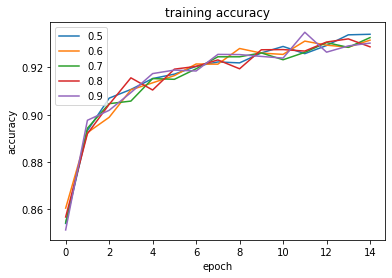

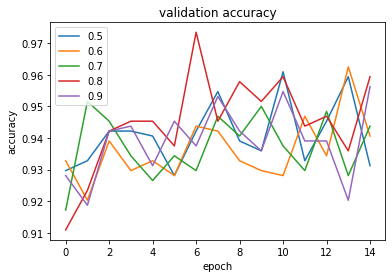

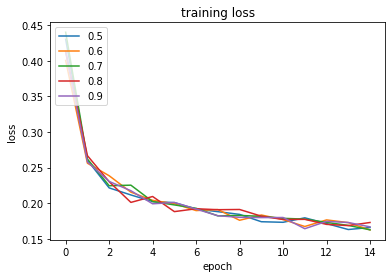

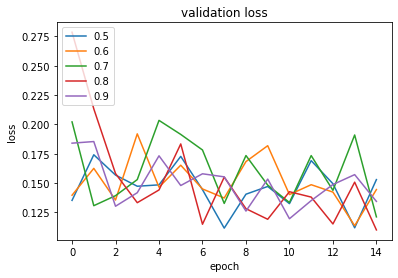

In [56]:
acc_dict = {}
loss_dict = {}

val_acc_dict = {}
val_loss_dict = {}

for i in [.5,.6,.7,.8,.9]:
    data_dir = '/Users/jimbest-devereux/Desktop/Autumn/CS 229/Project/Post-hurricane/train_another' #<- for local

    data_generator = DataGenerator(data_dir, amount=i)

    model = get_model(data_generator.encoder.all_damage_labels
    )

    model.fit_generator(
        data_generator.batch_generator('train', batch_size=BATCH_SIZE),
        steps_per_epoch=200,
        epochs=15,
        validation_data=data_generator.batch_generator(
            'validation',
            batch_size=BATCH_SIZE,
            augmented=False
        ),
        validation_steps=10
    )

    acc_dict[i] = model.history.history['accuracy']
    val_acc_dict[i] = model.history.history['val_accuracy']
    
    loss_dict[i] = model.history.history['loss']
    val_loss_dict[i] = model.history.history['val_loss']
    

for i in [.5,.6,.7,.8,.9]:
    plt.plot(acc_dict[i])
plt.title('training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(acc_dict.keys(), loc='upper left')
plt.show()

for i in [.5,.6,.7,.8,.9]:
    plt.plot(val_acc_dict[i])
plt.title('validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(val_acc_dict.keys(), loc='upper left')
plt.show()

for i in [.5,.6,.7,.8,.9]:
        plt.plot(loss_dict[i])
plt.title('training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loss_dict.keys(), loc='upper left')
plt.show()
    
for i in [.5,.6,.7,.8,.9]:
        plt.plot(val_loss_dict[i])
plt.title('validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(val_loss_dict.keys(), loc='upper left')
plt.show()

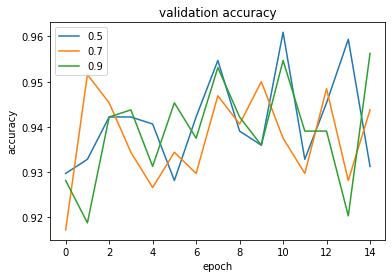

In [57]:
for i in [.5,.7,.9]:
    plt.plot(val_acc_dict[i])
plt.title('validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([.5,.7,.9], loc='upper left')
plt.show()


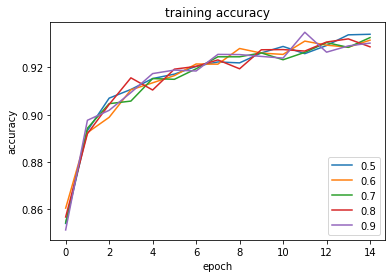

In [58]:
for i in [.5,.6,.7,.8,.9]:
    plt.plot(acc_dict[i])
plt.title('training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(acc_dict.keys(), loc='lower right')
plt.show()

In [22]:
test_paths = data_generator.partition2damage2npz['test']
print(len(test_paths['damage']) + len(test_paths['no_damage']))

1049


In [23]:
train_paths = data_generator.partition2damage2npz['train']
val_paths = data_generator.partition2damage2npz['validation']
print(len(train_paths['damage']) + len(train_paths['no_damage']))
print(len(val_paths['damage']) + len(val_paths['no_damage']))

6993
1958


In [123]:
idx = 0
damage_image_pixels = np.zeros((523, 128, 128, 3))
for pixels_path in tqdm.tqdm(list(test_paths['damage'])):
    damage_image_pixels[idx, :,:,:] = np.load(pixels_path)['pixels']
    idx +=1

idx = 0
no_damage_image_pixels = np.zeros((515, 128, 128, 3))
for pixels_path in tqdm.tqdm(list(test_paths['no_damage'])):
    no_damage_image_pixels[idx, :,:,:] = np.load(pixels_path)['pixels']
    idx +=1

100%|██████████| 515/515 [00:00<00:00, 649.13it/s]


In [124]:
damage_predicted_labels = model.predict(damage_image_pixels)
no_damage_predicted_labels = model.predict(no_damage_image_pixels)

In [127]:
correct_lab_damage = np.sum(damage_predicted_labels[:,0] > damage_predicted_labels[:,1])
correct_lab_no_damage = np.sum(no_damage_predicted_labels[:,0] < no_damage_predicted_labels[:,1])

print((correct_lab_damage + correct_lab_no_damage) / 1038)

0.9335260115606936


In [138]:
damage_predicted_labels.shape

(523, 2)

In [140]:
damage_pred = damage_predicted_labels[:,0] < damage_predicted_labels[:,1]
no_damage_pred = no_damage_predicted_labels[:,0] < no_damage_predicted_labels[:,1]

Text(0.5, 1.0, 'Confusion Matrix for Test Images')

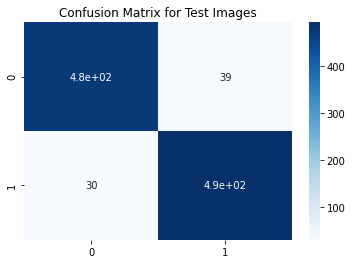

In [137]:
y_true = np.concatenate((np.zeros(no_damage_image_pixels.shape[0]), np.ones(damage_image_pixels.shape[0])))
y_pred = np.concatenate((damage_pred, no_damage_pred))
confusion_mat = sklearn.metrics.confusion_matrix(y_true, y_pred)
sn.heatmap(confusion_mat, annot=True, cmap="Blues")
plt.title("Confusion Matrix for Test Images")

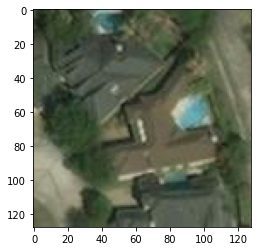

In [110]:
plt.imshow(no_damage_image_pixels[1,:,:,:] / 255)

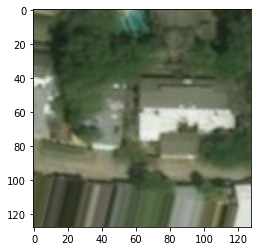

In [72]:
# example of vertical shift image augmentation
from numpy import expand_dims

train_paths = data_generator.partition2damage2npz['train']
image_pixels = np.load(random.choice(train_paths['no_damage']))['pixels']

image_datagen.flow(expand_dims(image_pixels, 0))
it = image_datagen.flow(expand_dims(image_pixels, 0), batch_size=1)

batch = it.next()
# convert to unsigned integers for viewing
image = batch[0].astype('uint8')
# plot raw pixel data
plt.imshow(image)


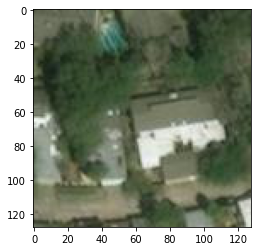

In [73]:
plt.imshow(image_pixels)